# Técnicas Matemáticas para Big Data - Project 1
## Teacher: Eugénio Rocha
## Students:
- Aamir Khan 117358
- Miguel Silva 102464
- Ricardo Dias 118372

# 1. Introduction

### 1.1 Bayesian Networks introduction

Bayesian Networks model conditional dependence between variables, where these variables are connected forming a network [1]. As Brownlee [2] puts it, "Bayesian networks are a probabilistic graphical model that explicitly capture the known conditional dependence with directed edges in a graph model". Bayesian Networks are acyclic, where the nodes correspond to the variables and the arrows represent the dependencies between them. The dependency between features is directed (indicating causality), which contributes to building models that infer the probability of certain events based on previously know variables.

As mentioned before, Bayesian Networks work based on conditional probabilities. For instance, if event A is conditionally dependent on event B, the probability of event A happending is P(A|B) = P(A, B) / P(B). Also, if event C is conditionally dependent on A and B, the likelihood of event C taking place if P(C|A, B) = P(A, B, C) / P(A, B), and so on. This is, therefore, the work basis of Bayesian Networks.

### 1.2 Breast cancer recurrence overview

Breast cancer recurrence is defined by the reappearance of cancer after treatment (locally of distant from the original place), and it may happen due to several factors, such as stage, treatment, age, and cancer type. For instance, women that have breast cancer before the age of 35 have a higher change of suffering recurrence. However, cancer recurrance risk can be reduced through irradiation therapy [3]. 

The breast cancer recurrence factors above mentioned are present in the Bayesian Network developed afterward.

### 1.3 Brief review on Bayesian Networks usage 

Ibeni et al. (2019) [4] have developed a Bayesian Network model for classifications of breast cancer recurrence. Simultaneously, the group developed models recurring to the following algorithms: Naїve Bayes, Tree Augmented Naїve Bayes, K-Nearest Neighbor, Support Vector Machine, and Decision Tree. They have implemented the algorithms with three different datasets concerning breast cancer, and one of them was the Breast Cancer dataset [5] available on UCI Machine Learning, which is the same dataset we are using in this project (the two other datasets aimed to classify cancer as benign/malign, and classify breast tissue according to a six-fold classification: carcinoma, fibro-adenoma, mastophaty, glandular, connective, and adipose). For the models' evaluation, they have reccurred to a 10-fold cross validation and, according to the group, the Bayesian Network algorithm was the one the higher accuracy (97.281%) on the Breast Cancer dataset, also scoring high values with precision, recall, and F1-score (all above 95%).

Arora et al. (2019) [6] have dicussed the usage of Bayesian Network for risk prediction as a tool in precision medicine, especially comparing with the traditional regression models. The group has concluded that regression models do not model causality, handle non-linear variables with difficulty, and multiple models are needed when facing various outcomes. As for the strengths of Bayesian Networks, it was stated that these networks allow causality between variables (which is beneficial for individual risk prediction), learn from both data and knowledge acquired before-hand (expert knowledge, such as known probilities), allow "what-if" scenarios, can incoporate decision nodes (extension to decision models), and can model multiple outcomes. However, Bayesian Networks are computationally demanding and are unnable to handle cyclical relationships between variables (feedback loops). 

# 2. First steps

In [43]:
# !pip install pgmpy
# !pip install pomegranate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from itertools import product
from fractions import Fraction

from pgmpy.models import BayesianNetwork

In [44]:
# avoid warnings of copy
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# avoid warnings of performance
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### 2.1 Importing the data

In [36]:
#pip install ucimlrepo

In [45]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer = fetch_ucirepo(id=14) 
  
# data (as pandas dataframes) 
X = breast_cancer.data.features 
y = breast_cancer.data.targets 
  
# metadata 
print(breast_cancer.metadata) 
  
# variable information 
print(breast_cancer.variables) 

{'uci_id': 14, 'name': 'Breast Cancer', 'repository_url': 'https://archive.ics.uci.edu/dataset/14/breast+cancer', 'data_url': 'https://archive.ics.uci.edu/static/public/14/data.csv', 'abstract': 'Breast Cancer Data (Restricted Access)', 'area': 'Life Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 286, 'num_features': 9, 'feature_types': ['Categorical'], 'demographics': ['Age'], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1988, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C51P4M', 'creators': ['Matjaz Zwitter', 'Milan Soklic'], 'intro_paper': None, 'additional_info': {'summary': 'This is one of three domains provided by the Oncology Institute that has repeatedly appeared in the machine learning literature. (See also lymphography and primary-tumor.)\r\n\r\nThis data set includes 201 instances of one class and 85 instances of another class. 

### 2.2 Basic acquaintance with the data

- Checking the first samples of the data frame.

In [46]:
df = pd.concat([X,y], axis=1)
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,30-39,premeno,30-34,0-2,no,3,left,left_low,no,no-recurrence-events
1,40-49,premeno,20-24,0-2,no,2,right,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left,left_low,no,no-recurrence-events
3,60-69,ge40,15-19,0-2,no,2,right,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events


- Checking the number of missing values from each variable.

In [47]:
df.isnull().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64

- Checking the amount of samples per value of each feature:

In [48]:
for feature in df.columns:
    print(feature)
    print(df[feature].value_counts())
    print("")

age
50-59    96
40-49    90
60-69    57
30-39    36
70-79     6
20-29     1
Name: age, dtype: int64

menopause
premeno    150
ge40       129
lt40         7
Name: menopause, dtype: int64

tumor-size
30-34     60
25-29     54
20-24     50
15-19     30
14-Oct    28
40-44     22
35-39     19
0-4        8
50-54      8
9-May      4
45-49      3
Name: tumor-size, dtype: int64

inv-nodes
0-2       213
5-Mar      36
8-Jun      17
11-Sep     10
15-17       6
14-Dec      3
24-26       1
Name: inv-nodes, dtype: int64

node-caps
no     222
yes     56
Name: node-caps, dtype: int64

deg-malig
2    130
3     85
1     71
Name: deg-malig, dtype: int64

breast
left     152
right    134
Name: breast, dtype: int64

breast-quad
left_low     110
left_up       97
right_up      33
right_low     24
central       21
Name: breast-quad, dtype: int64

irradiat
no     218
yes     68
Name: irradiat, dtype: int64

Class
no-recurrence-events    201
recurrence-events        85
Name: Class, dtype: int64



### 2.3. Several conclusions

We have decided to reduce the dataset to the following features:
 - age:<br>
    - Description: Represents the age of the patient.<br>
    - Type: Categorical<br>
    - Possible values: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99
 - menopause:<br>
    - Description: Indicates the menopausal status of the patient.<br>
    - Type: Categorical<br>
    - Possible Values: lt40, ge40, premeno.<br>
 - tumor-size:<br>
    - Description: Refers to the size of the tumor.<br>
    - Type: Categorical<br>
    - Possible values: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59
 - deg-malig:<br>
    - Description: Represents the degree of malignancy of the tumor.<br>
    - Type: Categorical<br>
    - Possible Values: 1,2,3.<br>
 - brest-quad:<br>
    - Description: Indicates the quadrant of the breast where the tumor is located.<br>
    - Type: Categorical<br>
    - Possible Values: central, left_low, left_up, right_low, right_up.<br>
 - irradiant:<br>
    - Description:Indicates whether the patient received irradiation treatment.<br>
    - Type: Binary<br>
    - Possible values: no, yes
 - Class:<br>
    - Description:Classify patients into the ones with no recurrence of breast cancer and the ones with recurrence events. <br>
    - Type: Binary<br>
    - Possible values: no-recurrence-events, recurrence-events

By checking data and seeing that we have a total of 8 missing values on the *node-caps* variable (this is irrelevant because this variable is going to be erased before dropping the missing values from the data frame) and 1 missing value on the *breast-quad* variable, it's safe to say that we can drop all those observations.

Finally, we have decided to drop the samples that have "menopause" = 'lt40' because we only have 7 samples (this may jeopardize network construction - we have analyzed the Bayesian network with 'lt40' and we have found some individuals that don't have both 'central' breast quadrant and 'lt40' menopause to build a layer in the network). 

In [49]:
# selecting relevant features
df = df[['age','menopause','tumor-size','deg-malig','breast-quad','irradiat','Class']]

# dropping NaN values
df = df.dropna()

# reseting index
df = df.reset_index(drop=True)

# renaming columns for readability
df.columns = ['age','menopause','tumor_size','deg_malig','breast_quad','irradiat','Class']

# dropping menpause = lt40
df = df.drop(index = df[df['menopause']=='lt40'].index, axis=0)

# reseting index
df = df.reset_index(drop=True)

In [50]:
df.head()

,age,menopause,tumor_size,deg_malig,breast_quad,irradiat,Class
0,30-39,premeno,30-34,3,left_low,no,no-recurrence-events
1,40-49,premeno,20-24,2,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,2,left_low,no,no-recurrence-events
3,60-69,ge40,15-19,2,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,2,right_low,no,no-recurrence-events


# 3. Reshaping feature values

### 3.1 Reshaping age groups

- Checking the number of samples per age group

In [51]:
df.age.value_counts()

50-59    91
40-49    90
60-69    55
30-39    35
70-79     6
20-29     1
Name: age, dtype: int64

- We can group ages by: 20-39, 40-49, 50-59, 60-79. Less groups decrease the complexity of the network.

In [52]:
# regrouping ages
for i in range(len(df.age)):
    
    if df.age[i] == '20-29' or df.age[i] == '30-39':
        df.age[i] = '20-39'

    elif df.age[i] == '60-69' or df.age[i] == '70-79': 
        df.age[i] = '60-79'

    # 40-49 and 50-59 mantain 

In [53]:
print(df.age.value_counts())
print("Successful age re-grouping")

50-59    91
40-49    90
60-79    61
20-39    36
Name: age, dtype: int64
Successful age re-grouping


### 3.2 Reshaping tumor-size groups

In [57]:
df.tumor_size.value_counts()

30-34     57
25-29     54
20-24     48
15-19     28
14-Oct    27
40-44     22
35-39     19
0-4        8
50-54      8
9-May      4
45-49      3
Name: tumor_size, dtype: int64

- As we can see, there are to labels of tumor_size that are wrongly written, in date format: "14-Oct" and "9-May". We need to replace them by "10-14" and "5-9", respectively.

In [58]:
# assessing wrongly written tumor sizes

for i in range(len(df.tumor_size)):
    
    if df.tumor_size[i] == '9-May':
        df.tumor_size[i] = '5-9'
        
    elif df.tumor_size[i] == '14-Oct':
        df.tumor_size[i] = '10-14'

In [59]:
df.tumor_size.value_counts()

30-34    57
25-29    54
20-24    48
15-19    28
10-14    27
40-44    22
35-39    19
0-4       8
50-54     8
5-9       4
45-49     3
Name: tumor_size, dtype: int64

- Now, we can group sizes of tumors by: 0-14, 15-24, 25-39, 40-54. Less groups decrease the complexity of the network.

In [60]:
for i in range(len(df.tumor_size)):
    
    if df.tumor_size[i] == '0-4' or df.tumor_size[i] == '5-9' or df.tumor_size[i] == '10-14':
        df.tumor_size[i] = '0-14'
    
    elif df.tumor_size[i] == '15-19' or df.tumor_size[i] == '20-24':
        df.tumor_size[i] = '15-24'
        
    elif df.tumor_size[i] == '25-29' or df.tumor_size[i] == '30-34' or df.tumor_size[i] == '35-39':
        df.tumor_size[i] = '25-39'
    
    elif df.tumor_size[i] == '40-44' or df.tumor_size[i] == '45-49' or df.tumor_size[i] == '50-54':
        df.tumor_size[i] = '40-54'

In [61]:
print(df.tumor_size.value_counts())
print("Successful tumor size re-grouping")

25-39    130
15-24     76
0-14      39
40-54     33
Name: tumor_size, dtype: int64
Successful tumor size re-grouping


### 3.3 Saving the dataset is ready for using

In [62]:
df.to_csv('breast_cancer.csv', index=False)

# 4. Building the Bayesian Network

### 4.1 Importing data

In [6]:
data = pd.read_csv('breast_cancer.csv')
data.head()

,age,menopause,tumor_size,deg_malig,breast_quad,irradiat,Class
0,20-39,premeno,25-39,3,left_low,no,no-recurrence-events
1,40-49,premeno,15-24,2,right_up,no,no-recurrence-events
2,40-49,premeno,15-24,2,left_low,no,no-recurrence-events
3,60-79,ge40,15-24,2,left_up,no,no-recurrence-events
4,40-49,premeno,0-14,2,right_low,no,no-recurrence-events


### 4.2 Defining the network

This cell defines the network to be implemented, were the pairs of variables represent the links of dependency from the network:
- ('age', 'menopause') represents the dependency of menopause on age;
- ('menopause', 'tumor_size') represents the dependency of tumor size on menopause;
- and so on.

In [40]:
model = BayesianNetwork([('age', 'menopause'), 
                         ('menopause', 'tumor_size'), 
                         ('breast_quad', 'tumor_size'), 
                         ('menopause', 'deg_malig'), 
                         ('tumor_size', 'deg_malig'), 
                         ('tumor_size','irradiat'), 
                         ('irradiat', 'Class'), 
                         ('deg_malig', 'Class')])


# checking the network structure summary
print(model)

BayesianNetwork with 7 nodes and 8 edges


### 4.3 Plotting the network

Given the Bayesian Network, this cell plots the shceme of the proposed network.

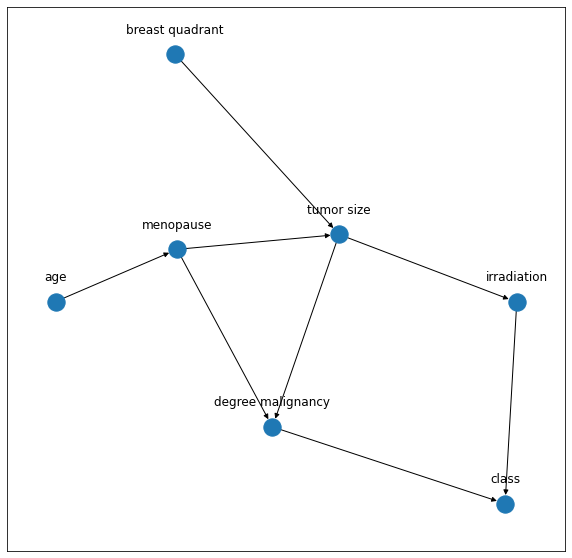

In [8]:
import networkx as nx

plt.figure(figsize=(10, 10))

G = nx.DiGraph()
G.add_edges_from(model.edges())

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos) #draws the nodes of the graph.
nx.draw_networkx_edges(G, pos, arrows=True) #draws the edges of the graph.
label_pos = {n: (x, y + 0.1) for n, (x, y) in pos.items()}

nx.draw_networkx_labels(G, label_pos, labels={n: x for n, x in zip(G, ['age','menopause', 'tumor size', 'degree malignancy', 'irradiation', 'breast quadrant', 'class'])})

# Show the plot

plt.show()



### 4.4 Tackling probabilities

##### 4.4.1 Defining the matrix with relationships between variables

This matrix "relationship" gives a boolean set of values that indicate whether the variables are connected in the network. So, to begin, the matrix is set to all False.

In [11]:
relationship = pd.DataFrame(False, index=data.columns, columns=data.columns)
relationship

,age,menopause,tumor_size,deg_malig,breast_quad,irradiat,Class
age,False,False,False,False,False,False,False
menopause,False,False,False,False,False,False,False
tumor_size,False,False,False,False,False,False,False
deg_malig,False,False,False,False,False,False,False
breast_quad,False,False,False,False,False,False,False
irradiat,False,False,False,False,False,False,False
Class,False,False,False,False,False,False,False


##### 4.4.2 Replacing values in the relationships matrix according to the network

Then, in the matrix "relationships", the values False are replaced by True for the pairs of variables that are connected in the network.

In [12]:
relationship.loc['age','menopause'] = True
relationship.loc['menopause','tumor_size'] = True
relationship.loc['menopause','deg_malig'] = True
relationship.loc['breast_quad','tumor_size'] = True
relationship.loc['tumor_size','irradiat'] = True
relationship.loc['tumor_size','deg_malig'] = True
relationship.loc['deg_malig','Class'] = True
relationship.loc['irradiat','Class'] = True

relationship

,age,menopause,tumor_size,deg_malig,breast_quad,irradiat,Class
age,False,True,False,False,False,False,False
menopause,False,False,True,True,False,False,False
tumor_size,False,False,False,True,False,True,False
deg_malig,False,False,False,False,False,False,True
breast_quad,False,False,True,False,False,False,False
irradiat,False,False,False,False,False,False,True
Class,False,False,False,False,False,False,False


##### 4.4.3 Function for calculating the conditional probabilities between events of variables

In [13]:
def calculate_probabilities(structural_matrix, data, target):
    """
    This function calculates the conditional probabilities of variables 
    according a structural_matrix that indicate the variables that are 
    connected in the network, the data set, and target variable whose
    probabilities the function determines.
    """
    
    # selects the variables on whom the target variable is dependent
    depedencies_cols = data.columns[structural_matrix[target]]
    # number unique combinations of values in the columns identified in dependencies_cols, as well as the target variable
    valcount = data[list(data.columns[structural_matrix[target]]) + [target]].value_counts()
    # list of possible values for each dependent variable
    alternatives = []
    
    for e in depedencies_cols:
        alternatives.append(list(data[e].unique()))
    
    #  all possible combinations of values for the dependent variables 
    pairs = list(product(*alternatives))
    #  list for pairs of value combinations and their conditional probabilities
    a = []
    size_series_sum = 0
    
    for e in pairs:
        try:
            a.append([e,valcount[e] / valcount[e].sum()])
            size_series_sum = size_series_sum + int(valcount[e].shape[0])
        except:
            print(e, 'Error')
        print(' ')
    
    return a, size_series_sum 

##### 4.4.4 Implementing the function for calculating the conditional probabilities, according to the network matrix

This cell prints all possible probabilities according to the network.

In [14]:
for e in data.columns:
    
    # list containing pairs of value combinations and their conditional probabilities
    lista = calculate_probabilities(relationship, data, e)[0]
    # list for dictionaries that will represent the conditional probabilities for the current column
    data_dict_list = []

    for item in lista:
        dep = item[0]
        
        for tags, values in zip(item[1].index, list(item[1])):
            dicionary = {}
            
            for dependencies_names,dependencies_vals in zip(data.columns[relationship[e]], dep):
                dicionary[dependencies_names] = dependencies_vals
            if len(dep) == 0:
                
                dicionary[e] = tags[0]
            else:    
                dicionary[e] = tags
            dicionary['prob'] = Fraction(values).limit_denominator()
            data_dict_list.append(dicionary)
        
    df = pd.DataFrame(data_dict_list)
    display(df)

,age,prob
0,50-59,91/278
1,40-49,45/139
2,60-79,61/278
3,20-39,18/139


,age,menopause,prob
0,20-39,premeno,1
1,40-49,premeno,9/10
2,40-49,ge40,1/10
3,60-79,ge40,1
4,50-59,ge40,58/91
5,50-59,premeno,33/91


,menopause,breast_quad,tumor_size,prob
0,premeno,left_low,25-39,13/29
1,premeno,left_low,15-24,19/58
2,premeno,left_low,0-14,7/58
3,premeno,left_low,40-54,3/29
4,premeno,right_up,25-39,3/4
5,premeno,right_up,15-24,3/20
6,premeno,right_up,40-54,1/10
7,premeno,left_up,25-39,27/47
8,premeno,left_up,15-24,8/47
9,premeno,left_up,40-54,6/47


,menopause,tumor_size,deg_malig,prob
0,premeno,25-39,2,37/78
1,premeno,25-39,3,1/3
2,premeno,25-39,1,5/26
3,premeno,15-24,2,23/38
4,premeno,15-24,1,4/19
5,premeno,15-24,3,7/38
6,premeno,0-14,2,11/20
7,premeno,0-14,1,7/20
8,premeno,0-14,3,1/10
9,premeno,40-54,2,9/14


,breast_quad,prob
0,left_low,107/278
1,left_up,47/139
2,right_up,16/139
3,right_low,12/139
4,central,21/278


,tumor_size,irradiat,prob
0,25-39,no,93/130
1,25-39,yes,37/130
2,15-24,no,61/76
3,15-24,yes,15/76
4,0-14,no,35/39
5,0-14,yes,4/39
6,40-54,no,7/11
7,40-54,yes,4/11


,deg_malig,irradiat,Class,prob
0,3,no,no-recurrence-events,28/53
1,3,no,recurrence-events,25/53
2,3,yes,recurrence-events,19/29
3,3,yes,no-recurrence-events,10/29
4,2,no,no-recurrence-events,78/97
5,2,no,recurrence-events,19/97
6,2,yes,no-recurrence-events,23/32
7,2,yes,recurrence-events,9/32
8,1,no,no-recurrence-events,53/60
9,1,no,recurrence-events,7/60


### 4.5 Building the model

In [16]:
#from scipy.stats import rv_discrete
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

##### 4.5.1 Defining probabilities

Probability of independent variables (*age* and *breast quadrant*):
- The order for age is "20-39", "40-49", "50-59", "60-79"
- The order for breast quadrant is "central", "left_low", "left_up", "right_down", "right_up"

In [17]:
age = np.reshape([18/139, 45/139, 91/278, 61/278], (4,1))
breast_quad = np.reshape([21/278, 107/278, 47/139, 12/139, 16/139], (5,1))

Probability of *menopause* knowing *age*:
- The order for menopause is "ge40", "premeno"
- The layout of the 2D array represents manopause as the rows and ageas columns

In [18]:
# P(menopause|age)
meno_age = [[0, 1/10, 58/91, 1], 
            [1, 9/10, 33/91, 0]]

Probability of *tumor size* knowing *breast quadrant* and *menopause*:
- The order for tumor size is "0-14", "15-24", "25-39", "40-54"
- The layout of the 2D array represents tumor_size as the rows and the combination of breast quadrant and menopause as columns ("central"+"ge40", "central+"premeno", "left_low"+"ge40", and so on)

In [19]:
# P(size|quadrant,menopause)
tumsiz_brequad_meno = [[1/3, 1/3, 1/7, 7/58, 6/47, 6/47, 1/8, 1/4, 1/12, 0], 
                       [1/3, 1/3, 13/49, 19/58, 18/47, 8/47, 1/8, 5/16, 1/6, 3/20], 
                       [1/4, 1/3, 22/49, 13/29, 16/47, 27/47, 3/4, 7/16, 5/12, 3/4], 
                       [1/12, 0, 1/7, 3/29, 7/47, 6/47, 0, 0, 1/3, 1/10]]

Probability of *degree of malignancy* knowing *menopause* and *tumor size*
- The order for degree of malignancy is 1, 2, 3
- The layout of the 2D array represents degree of malignancy as the rows and the combination of menopause and tumor size as columns ("g40"+"0-14", "ge40+"15-24", "ge40"+"25-39", "ge40"+"40-54", "premeno"+"0-14", and so on)

In [20]:
# P(degree|menopause,size)
degmalg_meno_tumsiz = [[11/19, 9/38, 5/26, 4/19, 7/20, 4/19, 5/26, 3/14], 
                       [7/19, 9/19, 17/52, 7/19, 11/20, 23/38, 37/78, 9/14], 
                       [1/19, 11/38, 25/52, 8/19, 1/10, 7/38, 1/3, 1/7]]

Probability of *irradiation* knowing *tumor size*
- The order for irradiation is "no", "yes"
- The layout of the 2D array represents irradiation as the rows and tumor size as columns

In [21]:
# P(irradiation|size)
irradiat_tumsiz = [[35/39, 61/76, 93/130, 7/11], 
                   [4/39, 15/76, 37/130, 4/11]]

Probability of *Recurrance* knowing *irradiation* and *degree of malignancy*
- The order for class is "no-recurrence-events", "recurrence-events"
- The layout of the 2D array represents class as the rows and the combination of degree of malignancy and irradiaton as columns ("1"+"no", "1"+"yes", "2"+"no", "2"+"yes", and so on)

In [22]:
# P(class|degree,irradiation)
class_irradiat_degmalg = [[53/60, 4/7, 78/97, 23/32, 28/53, 10/29], 
                          [7/60, 3/7, 19/97, 9/32, 25/53, 19/29]]

# Recurring to the pgmpy documentation:

##### 4.5.2 Creating the Bayesian Network with the conditional probabilities

- Conditional probability distribution (cpd) for INDEPENDENT variables with new format

In [23]:
# age
cpd_age = TabularCPD(variable='age', 
                     variable_card=4, 
                     values=age, 
                     state_names = {'age': ['20-39','40-49','50-59','60-79']})

# breast quadrant
cpd_breast_quad = TabularCPD(variable='breast_quad', 
                             variable_card=5, 
                             values=breast_quad, 
                             state_names = {'breast_quad': ['central','left_low','left_up','right_low','right_up']})

- Conditional probability distribution (cpd) for the rest of the variables

In [24]:
# menopause
cpd_menopause = TabularCPD(variable='menopause', 
                           variable_card=2, 
                           values=meno_age, 
                           evidence=['age'], 
                           evidence_card=[4], 
                           state_names = {'menopause': ['ge40', 'premeno'], 
                                          'age': ['20-39','40-49','50-59','60-79']})

# tumor size
cpd_tumor_size = TabularCPD(variable='tumor_size', 
                            variable_card=4, 
                            values=tumsiz_brequad_meno, 
                            evidence=['breast_quad', 'menopause'], 
                            evidence_card=[5, 2], 
                            state_names = {'tumor_size': ['0-14','15-24','25-39','40-54'], 
                                           'breast_quad': ['central','left_low','left_up','right_low','right_up'], 
                                           'menopause': ['ge40', 'premeno']})

# degree of malignancy
cpd_deg_malig = TabularCPD(variable='deg_malig', 
                           variable_card=3, 
                           values=degmalg_meno_tumsiz, 
                           evidence=['menopause', 'tumor_size'], 
                           evidence_card=[2, 4], 
                           state_names = {'deg_malig': [1, 2, 3], 
                                          'menopause': ['ge40', 'premeno'], 
                                          'tumor_size': ['0-14','15-24','25-39','40-54']})

# irradiation
cpd_irradiat = TabularCPD(variable='irradiat', 
                          variable_card=2, 
                          values=irradiat_tumsiz, 
                          evidence=['tumor_size'], 
                          evidence_card=[4], 
                          state_names = {'irradiat': ['no','yes'], 
                                         'tumor_size': ['0-14','15-24','25-39','40-54']})

# class
cpd_class = TabularCPD(variable='Class', 
                       variable_card=2, 
                       values=class_irradiat_degmalg, 
                       evidence=['irradiat', 'deg_malig'], 
                       evidence_card=[2, 3], 
                       state_names = {'Class': ['no-recurrence-events','recurrence-events'], 
                                      'irradiat': ['no','yes'], 
                                      'deg_malig': [1, 2, 3]})

- Fitting and experimenting the model

In [41]:
# Fitting the model
model.add_cpds(cpd_age, cpd_breast_quad, cpd_menopause, cpd_tumor_size, cpd_deg_malig, cpd_irradiat, cpd_class)
model.check_model()

infer = VariableElimination(model)
# example for checking
evidence = {'age': '20-39',
            'breast_quad':  'left_low', 
            'menopause': 'premeno', 
            'tumor_size': '15-24', 
            'deg_malig': 1, 
            'irradiat': 'yes'}
result = infer.query(variables=['Class'], evidence=evidence)
print(result)

+-----------------------------+--------------+
| Class                       |   phi(Class) |
+=============================+==============+
| Class(no-recurrence-events) |       0.7188 |
+-----------------------------+--------------+
| Class(recurrence-events)    |       0.2812 |
+-----------------------------+--------------+


# 5. Implementing the model with examples

Here, we are creating a function that asks the user the values for the parameters for assessing recurrence of cancer based on the model implemented before. However, the parameters are asked if they're are not giving by the user before hand.

In [36]:
def recurrence_predict(Model,evidence=False):
    """
    This function prints the probability of recurrence of breast cancer given
    the a dictionary evidence with the data from the patient. If evidence is
    not given, the parameters are input values asked by the function to the user.
    """
    
    parameters = {'age': ['20-39','40-49','50-59','60-79'], 
                  'breast_quad': ['central','left_low','left_up','right_low','right_up'], 
                  'menopause': ['ge40', 'premeno'],
                  'tumor_size': ['0-14','15-24','25-39','40-54'], 
                  'deg_malig': [1, 2, 3], 
                  'irradiat': ['no','yes'], 
                  'Class': ['no-recurrence-events','recurrence-events']}
    
    # in case evidence hasn't been given by the user
    if not evidence:
        evidence = {}
        for par in parameters:
            # stop when all parameters are input
            if par == 'Class': 
                break
            
            value = input(par + ' (insert according to pre-defined values): ')
            if par == 'deg_malig':
                try: 
                    value = int(value)
                except:
                    continue
            if value in parameters[par]:
                evidence[par] = value
        
    # check
    infer = VariableElimination(Model)
    result = infer.query(variables=['Class'], evidence=evidence)
    
    print('')
    display(evidence)
    print('')
    print(result)

### 5.1 Example 1

In [33]:
recurrence_predict(model, evidence={'age': '20-39', 'breast_quad': 'central', 'menopause': 'ge40', 'tumor_size': '40-54', 'deg_malig': 3, 'irradiat': 'yes'})

{'age': '20-39',
 'breast_quad': 'central',
 'menopause': 'ge40',
 'tumor_size': '40-54',
 'deg_malig': 3,
 'irradiat': 'yes'}


+-----------------------------+--------------+
| Class                       |   phi(Class) |
+=============================+==============+
| Class(no-recurrence-events) |       0.3448 |
+-----------------------------+--------------+
| Class(recurrence-events)    |       0.6552 |
+-----------------------------+--------------+


It suggests that, given the input features, the model assigns a higher probability to the "recurrence-events" class, indicating a higher likelihood of recurrence compared to no recurrence.

### 5.2 Example 2

In [34]:
recurrence_predict(model,evidence={'age': '20-39', 'breast_quad': 'right_low', 'menopause': 'premeno', 'tumor_size': '0-14', 'deg_malig': 2, 'irradiat': 'yes'})

{'age': '20-39',
 'breast_quad': 'right_low',
 'menopause': 'premeno',
 'tumor_size': '0-14',
 'deg_malig': 2,
 'irradiat': 'yes'}


+-----------------------------+--------------+
| Class                       |   phi(Class) |
+=============================+==============+
| Class(no-recurrence-events) |       0.5283 |
+-----------------------------+--------------+
| Class(recurrence-events)    |       0.4717 |
+-----------------------------+--------------+



In this case, the model assigns a higher probability to the "no-recurrence-events" class, indicating that, given the input features, there is a higher likelihood of no recurrence compared to recurrence.

### 5.3 Different Examples 

In [39]:
recurrence_predict(model)

# 6. Pro and Cons

Bayesian networks have several advantages. Firstly, they provide a natural and intuitive way to model uncertainty and probability, making them suitable for situations where uncertainty is inherent in the data. Additionally, the graphical representation of Bayesian networks makes them easy to understand and interpret, with nodes representing variables and edges representing probabilistic dependencies between variables. Bayesian networks also support incremental learning, allowing for easy updates as new data becomes available. Furthermore, they can perform well even with limited data, making them effective for small datasets. Lastly, Bayesian networks can be used to model and infer causal relationships between variables, which is valuable for understanding underlying mechanisms in a system.

However, there are also some drawbacks to consider. Inference in Bayesian networks can be computationally expensive, especially as the number of variables increases, which can limit scalability. The assumption of independence between features given the class label may not hold in real-world scenarios, leading to biased predictions. While Bayesian networks can handle small datasets well, accurately learning the parameters (conditional probabilities) requires a sufficiently large dataset. Additionally, Bayesian networks struggle with continuous variables as they are inherently discrete, often requiring discretization methods that introduce additional complexity. Lastly, Bayesian networks may have limited expressiveness when trying to model complex relationships that go beyond the acyclic nature of the network.

# 7. Future Improvements

To enhance the process, it is recommended to invest in advanced automation for data preprocessing. This would involve exploring methods for automatic detection of missing values, automatic handling of incorrect age formats, and other preprocessing steps, providing a more efficient and robust approach. Additionally, consider the application of automatic algorithms to optimize the structure of the Bayesian network, allowing the model to learn the relationship between variables directly from the data, rather than relying on manual definitions. An interactive graphical interface would be valuable, facilitating the exploration of the network, allowing users to visualize and interact with the structure, adjust evidence, and observe changes in probabilities. Furthermore, a sensitivity analysis could be implemented to evaluate the impact of small changes in input probabilities on the model's outputs, identifying the most influential variables in the predictions.

# 8. References

- [1] D. Soni. *Introduction to Bayesian Networks*. Towards Data Science. June 8, 2018.
- [2] J. Brownlee. *A Gentle Introduction to Bayesian Belief Networks*. Machine Learning Mastery. September 25, 2019.
- [3] Cleveland Clinic. *Breast Cancer Recurrence*. https://my.clevelandclinic.org/health/diseases/8328-breast-cancer-recurrence. October 10, 2023.
- [4] Ibeni, W.N. et al. (2019) ‘Comparative analysis on Bayesian classification for breast cancer problem’, Bulletin of Electrical Engineering and Informatics, 8(4). doi:10.11591/eei.v8i4.1628. 
- [5] Zwitter,Matjaz and Soklic,Milan. (1988). Breast Cancer. UCI Machine Learning Repository. https://doi.org/10.24432/C51P4M.
- [6] Arora, P. et al. (2019) ‘Bayesian networks for risk prediction using real-world data: A tool for Precision Medicine’, Value in Health, 22(4), pp. 439–445. doi:10.1016/j.jval.2019.01.006. 